<a href="https://colab.research.google.com/github/oytungunes/PythonCodeExamples/blob/main/Augmentationtobilstm_addnoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
import imblearn
import keras
from keras.utils import np_utils
from sklearn.model_selection import KFold, StratifiedKFold

from keras.layers import Dense, LSTM, Flatten, TimeDistributed, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.layers import Bidirectional



import scipy.io
import numpy as np

mat = scipy.io.loadmat('/content/drive/MyDrive/newwdata/featuresconcatpeoplewalking.mat')

In [71]:

#%%
X = mat['XTrainnew3'] #2 x 1178 x 141 , numoffeatures x timelength x sample
Y = mat['label'] # numofsample x 1 0s and 1s
X = X.reshape(X.shape[2],X.shape[1],X.shape[0])# 113 845 26

#%%


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.11, random_state=2)
X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.1, random_state=2)

y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)
y_test = np_utils.to_categorical(y_test)

mu=0
sigma= 1
noise = np.random.normal(mu, sigma, X_train.shape)
X_train_noisy1 = X_train + noise

noise = np.random.normal(mu, sigma, X_train.shape)
X_train_noisy2 = X_train + noise

noise = np.random.normal(mu, sigma, X_train.shape)
X_train_noisy3 = X_train + noise

noise = np.random.normal(mu, sigma, X_train.shape)
X_train_noisy4= X_train + noise

X_train_augmented = np.concatenate((X_train, X_train_noisy1,X_train_noisy2,X_train_noisy3,X_train_noisy4), axis=0)

print(X_train_noisy4.shape)
print(X_train_augmented.shape)

y_train_augmented = np.concatenate((y_train, y_train,y_train,y_train,y_train), axis=0)


print(y_train.shape)
print(y_train_augmented.shape)



(90, 845, 26)
(450, 845, 26)
(90, 2)
(450, 2)


Epoch 1/150
8/8 [==============================] - 13s 1s/step - loss: 0.6296 - acc: 0.6778 - val_loss: 0.3400 - val_acc: 0.9000 - lr: 0.0200
Epoch 2/150
8/8 [==============================] - 5s 542ms/step - loss: 0.2796 - acc: 0.9289 - val_loss: 0.2821 - val_acc: 0.9000 - lr: 0.0200
Epoch 3/150
8/8 [==============================] - 6s 787ms/step - loss: 0.1120 - acc: 0.9622 - val_loss: 0.4204 - val_acc: 0.9000 - lr: 0.0200
Epoch 4/150
8/8 [==============================] - 5s 662ms/step - loss: 0.1144 - acc: 0.9756 - val_loss: 0.0630 - val_acc: 1.0000 - lr: 0.0200
Epoch 5/150
8/8 [==============================] - 3s 395ms/step - loss: 0.0496 - acc: 0.9844 - val_loss: 0.3520 - val_acc: 0.9000 - lr: 0.0200
Epoch 6/150
8/8 [==============================] - 3s 394ms/step - loss: 0.0470 - acc: 0.9911 - val_loss: 0.4196 - val_acc: 0.9000 - lr: 0.0200
Epoch 7/150
8/8 [==============================] - 3s 388ms/step - loss: 0.0335 - acc: 0.9978 - val_loss: 0.4389 - val_acc: 0.8000 - lr: 0

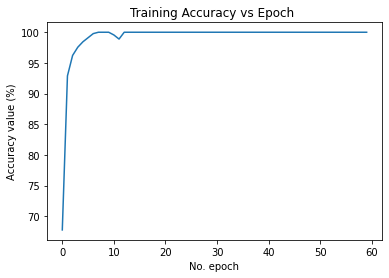

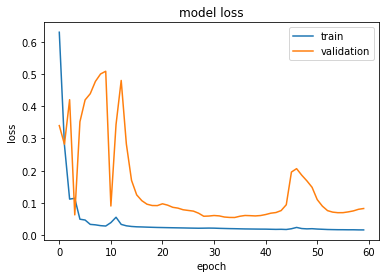

In [72]:
#%%
#
from keras.layers import Dense, LSTM, Flatten, TimeDistributed, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras import regularizers
import tensorflow as tf 

numberOfHiddenUnits =10 # calisan 8
model = Sequential()
model.add(Bidirectional(LSTM(numberOfHiddenUnits)))
model.add(Dense(2, activation='sigmoid',activity_regularizer=regularizers.L2(0.001),kernel_regularizer=regularizers.L2(0.001)))
opt = tf.keras.optimizers.Adam(0.02)
#model.compile(loss="categorical_crosse#ntropy", optimizer=optimizer, metrics=['acc'])
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=['acc'])


mycallbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.1, patience=25, min_lr=0
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=25,verbose=1),
]



#print(model.summary())
history= model.fit(X_train_augmented, y_train_augmented,validation_data=(X_val, y_val),batch_size=64,epochs=150,callbacks =[mycallbacks],verbose=1)
#history= model.fit(X_train, y_train,validation_data=(X_val, y_val),batch_size=64,epochs=100,verbose=1)

#%%

import matplotlib.pyplot as plt

myacc = history.history['acc']
trainingaccuracy= myacc[-1]
accuracy = [x * 100 for x in myacc]

plt.figure(2)
plt.plot(accuracy)
plt.title('Training Accuracy vs Epoch ')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()



# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()














In [73]:


model= keras.models.load_model('best_model.h5')

from sklearn.metrics import f1_score

integery_hat=np.argmax(model.predict(X_test), axis=1)
integery_test=np.argmax(y_test, axis=1)

list1 = list(integery_hat)
list2 = list(integery_test)

trainloss, train_acc = model.evaluate(X_train_augmented, y_train_augmented)
valloss, val_acc = model.evaluate(X_val, y_val)
testloss,test_acc = model.evaluate(X_test,y_test)

print("Train Accuracy",train_acc)
print("Val Accuracy",val_acc)
print("Test Accuracy",test_acc)


f1score = f1_score(list2, list1)

print("F1 SCORE",f1score)


1/1 [==============================] - 0s 76ms/step - loss: 0.2108 - acc: 0.9231
Train Accuracy 1.0
Val Accuracy 1.0
Test Accuracy 0.9230769276618958
F1 SCORE 0.9473684210526316


Epoch 1/150
2/2 [==============================] - 7s 1s/step - loss: 0.7038 - acc: 0.4556 - val_loss: 0.6017 - val_acc: 1.0000 - lr: 0.0200
Epoch 2/150
2/2 [==============================] - 1s 440ms/step - loss: 0.5823 - acc: 0.8889 - val_loss: 0.4444 - val_acc: 1.0000 - lr: 0.0200
Epoch 3/150
2/2 [==============================] - 1s 485ms/step - loss: 0.4338 - acc: 0.9222 - val_loss: 0.2358 - val_acc: 1.0000 - lr: 0.0200
Epoch 4/150
2/2 [==============================] - 1s 830ms/step - loss: 0.2726 - acc: 0.9444 - val_loss: 0.1195 - val_acc: 1.0000 - lr: 0.0200
Epoch 5/150
2/2 [==============================] - 1s 584ms/step - loss: 0.1771 - acc: 0.9444 - val_loss: 0.0728 - val_acc: 1.0000 - lr: 0.0200
Epoch 6/150
2/2 [==============================] - 2s 1s/step - loss: 0.1274 - acc: 0.9556 - val_loss: 0.0512 - val_acc: 1.0000 - lr: 0.0200
Epoch 7/150
2/2 [==============================] - 2s 734ms/step - loss: 0.0987 - acc: 0.9778 - val_loss: 0.0404 - val_acc: 1.0000 - lr: 0.020

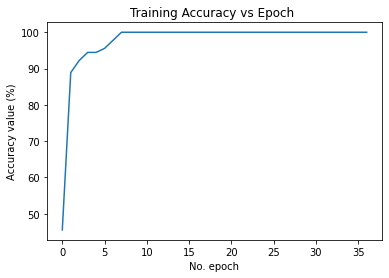

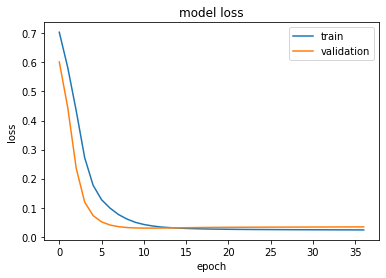

In [61]:
from keras.layers import Dense, LSTM, Flatten, TimeDistributed, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras import regularizers
import tensorflow as tf 

numberOfHiddenUnits =10 # calisan 8
model = Sequential()
model.add(Bidirectional(LSTM(numberOfHiddenUnits)))
model.add(Dense(2, activation='sigmoid',activity_regularizer=regularizers.L2(0.001),kernel_regularizer=regularizers.L2(0.001)))
opt = tf.keras.optimizers.Adam(0.02)
#model.compile(loss="categorical_crosse#ntropy", optimizer=optimizer, metrics=['acc'])
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=['acc'])


mycallbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.1, patience=25, min_lr=0
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=25,verbose=1),
]



#print(model.summary())
history= model.fit(X_train, y_train,validation_data=(X_val, y_val),batch_size=64,epochs=150,callbacks =[mycallbacks],verbose=1)
#history= model.fit(X_train, y_train,validation_data=(X_val, y_val),batch_size=64,epochs=100,verbose=1)

#%%

import matplotlib.pyplot as plt

myacc = history.history['acc']
trainingaccuracy= myacc[-1]
accuracy = [x * 100 for x in myacc]

plt.figure(2)
plt.plot(accuracy)
plt.title('Training Accuracy vs Epoch ')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()



# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()



In [62]:
model= keras.models.load_model('best_model.h5')

from sklearn.metrics import f1_score

integery_hat=np.argmax(model.predict(X_test), axis=1)
integery_test=np.argmax(y_test, axis=1)

list1 = list(integery_hat)
list2 = list(integery_test)

trainloss, train_acc = model.evaluate(X_train, y_train)
valloss, val_acc = model.evaluate(X_val, y_val)
testloss,test_acc = model.evaluate(X_test,y_test)

print("Train Accuracy",train_acc)
print("Val Accuracy",val_acc)
print("Test Accuracy",test_acc)


f1score = f1_score(list2, list1)

print("F1 SCORE",f1score)

1/1 [==============================] - 0s 76ms/step - loss: 0.2178 - acc: 0.9231
Train Accuracy 1.0
Val Accuracy 1.0
Test Accuracy 0.9230769276618958
F1 SCORE 0.888888888888889


In [ ]:

import matplotlib.pyplot as plt 
    
# x axis values 
x = list(np.arange(1,25+1))

# corresponding y axis values  
y=X_train[1,0:25,1]
# plotting the points  

fig, ax = plt.subplots()


ax.plot(x, y,label = 'original signal') 

mu=0
sigma= 0.1
noise = np.random.normal(mu, sigma, y.shape)
y2= y+noise
    
# naming the x axis 
plt.xlabel('x - axis') 
# naming the y axis 
plt.ylabel('y - axis') 
    
# giving a title to my graph 
plt.title('My first graph!') 
    
# function to show the plot 




ax.plot(x, y2,label ='noisy signal') 
# naming the x axis 
plt.xlabel('x - axis') 
# naming the y axis 
plt.ylabel('y - axis') 
    
# giving a title to my graph 
plt.title('Adding noise to time series data')

ax.legend(['Original Signal', 'Noisy Signal'])

# function to show the plot 
plt.show() 